In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

import copy
import time
from pyDOE import lhs

In [2]:
np.random.seed(123)
torch.manual_seed(123)

torch.set_default_dtype(torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(torch.cuda.get_device_name())

Quadro RTX 4000


In [3]:
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__()

        self.depth = len(layers) - 1
        self.activation = nn.Tanh()
        self.linears = nn.ModuleList([nn.Linear(layers[i],layers[i+1]) for i in range(self.depth)])

        # Param Initialization
        for i in range(self.depth):
            nn.init.xavier_normal_(self.linears[i].weight.data)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self,x):
        for i in range(self.depth-1):
            y = self.linears[i](x)
            x = self.activation(y)
        
        return self.linears[-1](x)

In [4]:
class PhysicalInformedNN():
    def __init__(self,X_0,u0,X_b,X_star,U_star,X_f,layers):
        self.x0 = torch.tensor(X_0[:,0:1]).float().to(device)
        self.t0 = torch.tensor(X_0[:,1:2]).float().to(device)
        self.u0 = torch.tensor(u0).float().to(device)

        X_lb,X_rb = X_b["lb"],X_b["rb"]
        self.x_lb = torch.tensor(X_lb[:,0:1],requires_grad=True).float().to(device)
        self.t_lb = torch.tensor(X_lb[:,1:2],requires_grad=True).float().to(device)

        self.x_rb = torch.tensor(X_rb[:,0:1],requires_grad=True).float().to(device)
        self.t_rb = torch.tensor(X_rb[:,1:2],requires_grad=True).float().to(device)

        self.x_f = torch.tensor(X_f[:,0:1],requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,1:2],requires_grad=True).float().to(device)

        self.x_star = torch.tensor(X_star[:,0:1]).float().to(device)
        self.t_star = torch.tensor(X_star[:,1:2]).float().to(device)
        self.u_star = torch.tensor(U_star).float().to(device)
        
        self.NN = DNN(layers).to(device)

        self.optimizer_LBFGS = optim.LBFGS(
            self.NN.parameters(),
            lr = 1.0,
            max_iter=10000,
            max_eval=20000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0*np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_Adam_star = optim.Adam(self.NN.parameters(),lr = 5e-4)
        self.optimizer_Adam = optim.Adam(self.NN.parameters())

        self.verbose = False
        self.n = 0

    def net_u(self,x,t):
        u =  self.NN(torch.concat([x,t],dim=1))
        return u
    
    def net_uv(self,x,t):
        u = self.net_u(x,t)
        ux = autograd.grad(
            u,x,
            grad_outputs=torch.ones_like(u),
            retain_graph = True,
            create_graph = True)[0] 
        return u,ux

    def net_f(self,x,t):
        u = self.net_u(x,t)
        
        du = autograd.grad(
            u,[x,t],
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)

        u_xx = autograd.grad(
            du[0],x,
            grad_outputs=torch.ones_like(du[0]),
            retain_graph=True,
            create_graph=True)

        f = du[1] - 0.0001*u_xx[0] + 5*u**3 - 5*u
        return f

    def closure(self):
        self.optimizer_Adam.zero_grad()
        
        u0_pred = self.net_u(self.x0,self.t0)
        u_lb_pred,u_x_lb_pred = self.net_uv(self.x_lb,self.t_lb)
        u_rb_pred,u_x_rb_pred = self.net_uv(self.x_rb,self.t_rb)
        f_pred = self.net_f(self.x_f,self.t_f)

        loss = 64*torch.mean(torch.square(u0_pred - self.u0)) +\
            torch.mean(torch.square(u_lb_pred - u_rb_pred)) +\
            torch.mean(torch.square(u_x_lb_pred - u_x_rb_pred)) +\
            torch.mean(torch.square(f_pred))
        
        loss.backward()

        if self.verbose:
            self.n += 1
            print(f"It:{self.n}, Lose: {loss.detach().cpu().numpy():.3e}")
        
        return loss

    def train(self,nIters):
        start_time = time.time()
        for it in range(nIters):
            if it <= nIters/10:
                # ICGL (10% Adam Iterations)
                self.optimizer_Adam_star.zero_grad()
                u_star = self.net_u(self.x_star,self.t_star)
                loss_star = torch.mean(torch.square(u_star-self.u_star) + torch.abs(u_star - self.u_star))
                loss_star.backward()
                self.optimizer_Adam_star.step()

                if it%10 == 0:
                    elapsed = time.time() - start_time
                    print(f"It: {it}, Loss: {loss_star.detach().cpu().numpy():.3e}, Time: {elapsed:.2f}")
                    start_time = time.time()
            else:
                self.optimizer_Adam.step(self.closure)
                if it%10 == 0:
                    elapsed = time.time() - start_time
                    u0_pred = self.net_u(self.x0,self.t0)
                    u_lb_pred,u_x_lb_pred = self.net_uv(self.x_lb,self.t_lb)
                    u_rb_pred,u_x_rb_pred = self.net_uv(self.x_rb,self.t_rb)
                    f_pred = self.net_f(self.x_f,self.t_f)
                    loss_u0 = torch.mean(torch.square(u0_pred - self.u0) + torch.abs(u0_pred - self.u0))
                    loss_ub = torch.mean(torch.square(u_lb_pred - u_rb_pred) + torch.abs(u_lb_pred - u_rb_pred)) + \
                              torch.mean(torch.square(u_x_lb_pred - u_x_rb_pred) + torch.abs(u_x_lb_pred - u_x_rb_pred))
                    loss_f = torch.mean(torch.square(f_pred)+ torch.abs(f_pred))
                    loss = loss_u0 + loss_ub + loss_f
                    print(f"It: {it}, Loss: {loss.detach().cpu().numpy():.3e}, Loss_u0: {loss_u0.detach().cpu().numpy():.3e}, Loss_ub: {loss_ub.detach().cpu().numpy():.3e}, Loss_f: {loss_f.detach().cpu().numpy():.3e}, Time: {elapsed:.2f}")

                    start_time = time.time()
        print("LBFGS refine")                    
        self.verbose = True
        self.optimizer_LBFGS.step(self.closure)
        self.verbose = False
   
    def predict(self,X):
        self.NN.eval()
        x = torch.tensor(X[:,0:1]).float().to(device)
        t = torch.tensor(X[:,1:2]).float().to(device)
        u = self.net_u(x,t)
        return u.detach().cpu().numpy()
        

In [5]:
class bcPhysicalInformedNN():
    def __init__(self,X_pre,U_pre,X_star,U_star,X_0,U_0,X_b,X_f,Network):
        self.x_p = torch.tensor(X_pre[:,0:1]).float().to(device)
        self.t_p = torch.tensor(X_pre[:,1:2]).float().to(device)
        self.u_p = torch.tensor(U_pre).float().to(device)
        
        self.x0 = torch.tensor(X_0[:,0:1]).float().to(device)
        self.t0 = torch.tensor(X_0[:,1:2]).float().to(device)
        self.u0 = torch.tensor(U_0).float().to(device)

        X_lb,X_rb = X_b["lb"],X_b["rb"]
        self.x_lb = torch.tensor(X_lb[:,0:1],requires_grad=True).float().to(device)
        self.t_lb = torch.tensor(X_lb[:,1:2],requires_grad=True).float().to(device)

        self.x_rb = torch.tensor(X_rb[:,0:1],requires_grad=True).float().to(device)
        self.t_rb = torch.tensor(X_rb[:,1:2],requires_grad=True).float().to(device)

        self.x_f = torch.tensor(X_f[:,0:1],requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,1:2],requires_grad=True).float().to(device)

        self.x_star = torch.tensor(X_star[:,0:1]).float().to(device)
        self.t_star = torch.tensor(X_star[:,1:2]).float().to(device)
        self.u_star = torch.tensor(U_star).float().to(device)
        
        self.NN = Network 

        self.optimizer_LBFGS = optim.LBFGS(
            self.NN.parameters(),
            lr = 1.0,
            max_iter=10000,
            max_eval=20000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0*np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_Adam_star = optim.Adam(self.NN.parameters(),lr = 5e-4)
        self.optimizer_Adam = optim.Adam(self.NN.parameters())

        self.verbose = False
        self.n = 0

    def net_u(self,x,t):
        u =  self.NN(torch.concat([x,t],dim=1))
        return u
    
    def net_uv(self,x,t):
        u = self.net_u(x,t)
        ux = autograd.grad(
            u,x,
            grad_outputs=torch.ones_like(u),
            retain_graph = True,
            create_graph = True)[0] 
        return u,ux

    def net_f(self,x,t):
        u = self.net_u(x,t)
        
        du = autograd.grad(
            u,[x,t],
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)

        u_xx = autograd.grad(
            du[0],x,
            grad_outputs=torch.ones_like(du[0]),
            retain_graph=True,
            create_graph=True)

        f = du[1] - 0.0001*u_xx[0] + 5*u**3 - 5*u
        return f

    def closure(self):
        self.optimizer_Adam.zero_grad()
        
        u0_pred = self.net_u(self.x0,self.t0)
        u_p_pred = self.net_u(self.x_p,self.t_p)
        u_lb_pred,u_x_lb_pred = self.net_uv(self.x_lb,self.t_lb)
        u_rb_pred,u_x_rb_pred = self.net_uv(self.x_rb,self.t_rb)
        f_pred = self.net_f(self.x_f,self.t_f)

        loss = 64*torch.mean(torch.square(u0_pred - self.u0)) +\
                torch.mean(torch.square(u_lb_pred - u_rb_pred)) +\
                torch.mean(torch.square(u_x_lb_pred - u_x_rb_pred)) +\
                torch.mean(torch.square(f_pred)) +\
               64*torch.mean(torch.square(u_p_pred - self.u_p)) 
        loss.backward()

        if self.verbose:
            self.n += 1
            print(f"It:{self.n}, Lose: {loss.detach().cpu().numpy():.3e}")
        
        return loss

    def train(self,nIters):
        start_time = time.time()
        self.NN.train()
        for it in range(nIters):
            if it <= nIters/10:
                # ICGL (10% Adam Iterations)
                self.optimizer_Adam_star.zero_grad()
                u_star = self.net_u(self.x_star,self.t_star)
                loss_star = torch.mean(torch.square(u_star-self.u_star))
                loss_star.backward()
                self.optimizer_Adam_star.step()

                if it%10 == 0:
                    elapsed = time.time() - start_time
                    print(f"It: {it}, Loss: {loss_star.detach().cpu().numpy():.3e}, Time: {elapsed:.2f}")
                    start_time = time.time()
            else:
                self.optimizer_Adam.step(self.closure)
                if it%10 == 0:
                    elapsed = time.time() - start_time
                    u_p_pred = self.net_u(self.x_p,self.t_p)
                    u0_pred = self.net_u(self.x0,self.t0)
                    u_lb_pred,u_x_lb_pred = self.net_uv(self.x_lb,self.t_lb)
                    u_rb_pred,u_x_rb_pred = self.net_uv(self.x_rb,self.t_rb)
                    f_pred = self.net_f(self.x_f,self.t_f)
                    
                    loss_u_p = torch.mean(torch.square(u_p_pred - self.u_p) + torch.abs(u_p_pred - self.u_p))
                    loss_u0 = torch.mean(torch.square(u0_pred - self.u0) + torch.abs(u0_pred - self.u0))
                    loss_ub = torch.mean(torch.square(u_lb_pred - u_rb_pred) + torch.abs(u_lb_pred - u_rb_pred)) + \
                              torch.mean(torch.square(u_x_lb_pred - u_x_rb_pred) + torch.abs(u_x_lb_pred - u_x_rb_pred))
                    loss_f = torch.mean(torch.square(f_pred)+ torch.abs(f_pred))
                    loss = loss_u0 + loss_ub + loss_f + loss_u_p
                    print(f"It: {it}, Loss: {loss.detach().cpu().numpy():.3e}, Loss_u_p: {loss_u_p.detach().cpu().numpy():.3e}, Loss_u0: {loss_u0.detach().cpu().numpy():.3e}, Loss_ub: {loss_ub.detach().cpu().numpy():.3e}, Loss_f: {loss_f.detach().cpu().numpy():.3e}, Time: {elapsed:.2f}")

                    start_time = time.time()
        print("LBFGS refine")                    
        self.verbose = True
        self.optimizer_LBFGS.step(self.closure)
        self.verbose = False
   
    def predict(self,X):
        self.NN.eval()
        x = torch.tensor(X[:,0:1]).float().to(device)
        t = torch.tensor(X[:,1:2]).float().to(device)
        u = self.net_u(x,t)
        return u.detach().cpu().numpy()
    

# bc-PINN to solve AC eq

In [6]:
layers = [2,128,128,128,128,128,128,1]

Nx = 128
N_b = 25

x0 = np.linspace(-1,1,Nx+1).reshape(-1,1)
u0 = x0**2*np.cos(np.pi*x0)

T = 1
Nt = 4
time_segment = np.linspace(0,T,Nt+1)
time_segment = np.vstack([time_segment[:-1],time_segment[1:]]).T

iterations = 10000
N_f = 20000

In [9]:
for No_seg in range(Nt):
    # Data Preparing
    lb = np.array([-1,time_segment[No_seg,0]])
    ub = np.array([1,time_segment[No_seg,1]])

    X_0 = np.concatenate([x0,lb[1]*np.ones_like(x0)],axis=1)
    if No_seg > 0:
        u0 = globals()[f"PINN_{No_seg-1}"].predict(X_0)

    tb = np.linspace(lb[1],ub[1],N_b+1).reshape(-1,1)
    X_b = {"lb":np.concatenate([lb[0]*np.ones_like(tb),tb],axis=1),
           "rb":np.concatenate([ub[0]*np.ones_like(tb),tb],axis=1)}

    t = np.linspace(lb[1],ub[1],50+1).reshape(-1,1)
    X,T = np.meshgrid(x0,t)
    X_star = np.concatenate((X.reshape(-1,1),T.reshape(-1,1)),axis=-1)
    U_star = np.tile(u0,(len(t),1))

    X_f = lb + (ub-lb)*lhs(2,N_f)
    X_f = np.concatenate([X_f,X_b["lb"],X_b["rb"],X_0])

    if No_seg == 0:
        globals()[f"PINN_{No_seg}"] = PhysicalInformedNN(X_0,u0,X_b,X_star,U_star,X_f,layers)
        globals()[f"PINN_{No_seg}"].train(iterations)

    else:
        globals()[f"PINN_{No_seg}"] = bcPhysicalInformedNN(X_p,U_p,X_star,U_star,X_0,u0,X_b,X_f,globals()[f"Network_{No_seg-1}"])
        globals()[f"PINN_{No_seg}"].train(iterations)

    globals()[f"Network_{No_seg}"] = copy.deepcopy(globals()[f"PINN_{No_seg}"].NN)
    
    tp = np.linspace(0,ub[1],N_b*(No_seg+1)+1).reshape(-1,1)
    Xp,Tp = np.meshgrid(x0,tp)
    X_p = np.concatenate((Xp.reshape(-1,1),Tp.reshape(-1,1)),axis = 1)
    U_p = globals()[f"PINN_{No_seg}"].predict(X_p)

It: 0, Loss: 4.248e-01, Time: 1.96
It: 10, Loss: 3.688e-01, Time: 0.06
It: 20, Loss: 3.678e-01, Time: 0.05
It: 30, Loss: 3.662e-01, Time: 0.05
It: 40, Loss: 3.656e-01, Time: 0.05
It: 50, Loss: 3.650e-01, Time: 0.05
It: 60, Loss: 3.641e-01, Time: 0.06
It: 70, Loss: 3.618e-01, Time: 0.04
It: 80, Loss: 3.462e-01, Time: 0.04
It: 90, Loss: 2.241e-01, Time: 0.06
It: 100, Loss: 1.693e-01, Time: 0.06
It: 110, Loss: 1.354e-01, Time: 0.04
It: 120, Loss: 1.201e-01, Time: 0.05
It: 130, Loss: 1.082e-01, Time: 0.05
It: 140, Loss: 1.257e-01, Time: 0.04
It: 150, Loss: 1.103e-01, Time: 0.06
It: 160, Loss: 9.748e-02, Time: 0.05
It: 170, Loss: 9.415e-02, Time: 0.04
It: 180, Loss: 9.116e-02, Time: 0.06
It: 190, Loss: 9.527e-02, Time: 0.05
It: 200, Loss: 9.588e-02, Time: 0.05
It: 210, Loss: 8.132e-02, Time: 0.05
It: 220, Loss: 8.652e-02, Time: 0.05
It: 230, Loss: 8.630e-02, Time: 0.05
It: 240, Loss: 7.299e-02, Time: 0.05
It: 250, Loss: 6.335e-02, Time: 0.05
It: 260, Loss: 5.874e-02, Time: 0.05
It: 270, Los

In [11]:
Path = "./bcPINN_AC_0001"
if not os.path.exists(Path):
    os.makedirs(Path)

code = str(int(time.time()))[-4:]
path = os.path.join(Path,f"model_{code}.pkl")

torch.save({(f"NN_{i}",globals()[f"PINN_{i}"].NN) for i in range(Nt)},path)

Text(0.5, 1.0, '$u_n-u$')

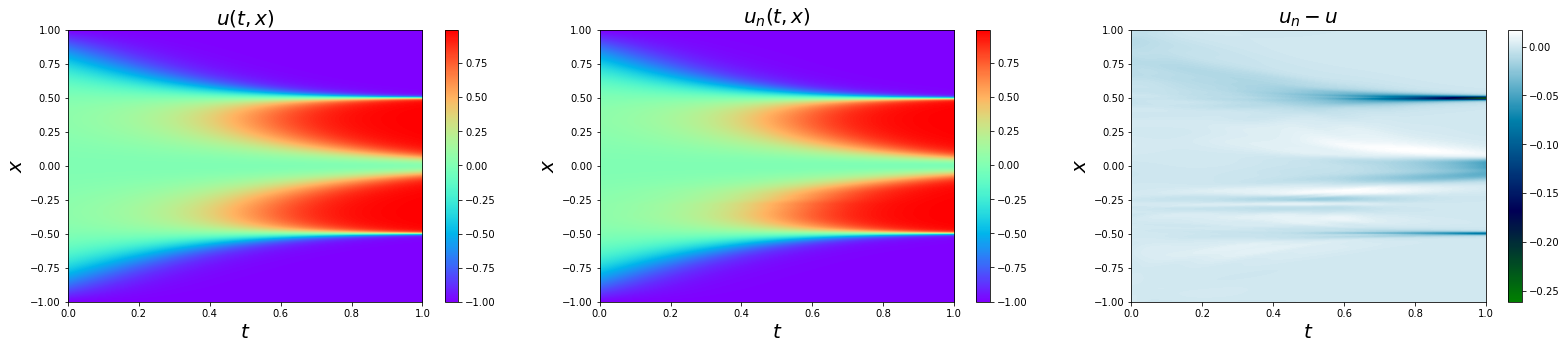

In [74]:
data = scipy.io.loadmat("./AC_R_1.mat")
x = data["x"]
t = data["tt"]
u_real = data["uu"].T

X,T = np.meshgrid(x,t)
X_p = np.concatenate((X.flatten()[:,None],T.flatten()[:,None]),axis=1)
u_predict = PINN_3.predict(X_p).reshape(X.shape)

fig = plt.figure(figsize=(27,5))
ax = fig.add_subplot(131)

h = ax.imshow(u_real.T,interpolation = "bilinear",cmap = "rainbow",
              extent = [t.min(), t.max(), x.min(), x.max()],
              origin = "lower", aspect= "auto")

cbar = fig.colorbar(h)

ax.set_xlabel("$t$",size = 20)
ax.set_ylabel("$x$",size = 20)
ax.set_title("$u(t,x)$",fontsize = 20)

ax2 = fig.add_subplot(132)

h = ax2.imshow(u_predict.T,interpolation = "bilinear",cmap = "rainbow",
              extent = [t.min(), t.max(), x.min(), x.max()],
              origin = "lower", aspect= "auto")

cbar = fig.colorbar(h)

ax2.set_xlabel("$t$",size = 20)
ax2.set_ylabel("$x$",size = 20)
ax2.set_title("$u_n(t,x)$",fontsize = 20)


ax3 = fig.add_subplot(133)
error = u_predict - u_real

h = ax3.imshow(error.T,interpolation = "bilinear",cmap = "ocean",
              extent = [t.min(), t.max(), x.min(), x.max()],
              origin = "lower", aspect= "auto")

cbar = fig.colorbar(h)

ax3.set_xlabel("$t$",size = 20)
ax3.set_ylabel("$x$",size = 20)
ax3.set_title("$u_n-u$",fontsize = 20)

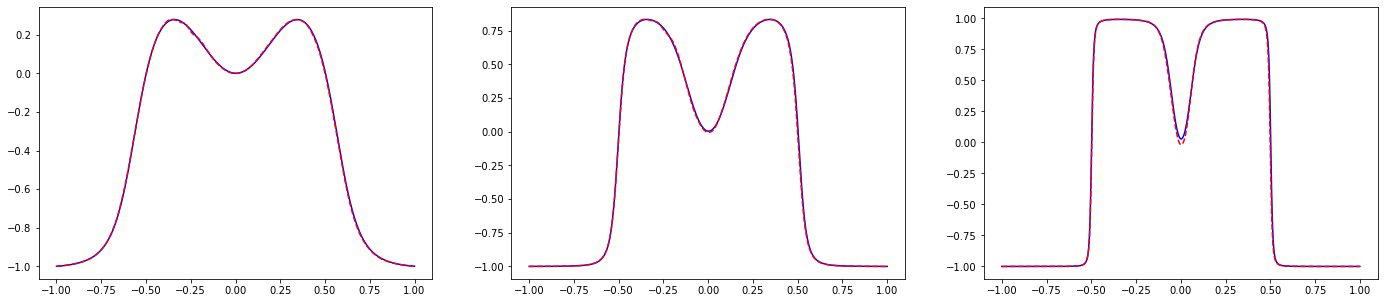

In [69]:
# 0.33, 0.66, 0.99
index_3 = np.where(t.flatten() == 0.33)[0].item()
index_6 = np.where(t.flatten() == 0.66)[0].item()
index_9 = np.where(t.flatten() == 0.99)[0].item()

u_3,u_p_3 = u_real[index_3,:],u_predict[index_3,:]
u_6,u_p_6 = u_real[index_6,:],u_predict[index_6,:]
u_9,u_p_9 = u_real[index_9,:],u_predict[index_9,:]

fig = plt.figure(figsize=(24,5))

ax = fig.add_subplot(131)
ax.plot(x[0],u_3,"b")
ax.plot(x[0],u_p_3,"r--")

ax = fig.add_subplot(132)
ax.plot(x[0],u_6,"b")
ax.plot(x[0],u_p_6,"r--")

ax = fig.add_subplot(133)
ax.plot(x[0],u_9,"b")
ax.plot(x[0],u_p_9,"r--")


In [45]:
error = np.linalg.norm(error)/np.linalg.norm(u_real,2)
print(f"Error u: {error:.5e}")

Error u: 1.80033e-02


# PINN to solve AC eq

In [71]:
lb = np.array([-1,0])
ub = np.array([1,1])

X_0 = np.concatenate([x0,lb[1]*np.ones_like(x0)],axis=1)
u0 = x0**2*np.cos(np.pi*x0)

tb = np.linspace(lb[1],ub[1],4*N_b+1).reshape(-1,1)
X_b = {"lb":np.concatenate([lb[0]*np.ones_like(tb),tb],axis=1),
    "rb":np.concatenate([ub[0]*np.ones_like(tb),tb],axis=1)}

t = np.linspace(lb[1],ub[1],150+1).reshape(-1,1)
X,T = np.meshgrid(x0,t)
X_star = np.concatenate((X.reshape(-1,1),T.reshape(-1,1)),axis=-1)
U_star = np.tile(u0,(len(t),1))

X_f = lb + (ub-lb)*lhs(2,N_f*3)
X_f = np.concatenate([X_f,X_b["lb"],X_b["rb"],X_0])

PINN = PhysicalInformedNN(X_0,u0,X_b,X_star,U_star,X_f,layers)
PINN.train(iterations)

It: 0, Loss: 5.011e-01, Time: 0.01
It: 10, Loss: 3.813e-01, Time: 0.08
It: 20, Loss: 3.654e-01, Time: 0.07
It: 30, Loss: 3.395e-01, Time: 0.05
It: 40, Loss: 2.407e-01, Time: 0.04
It: 50, Loss: 2.217e-01, Time: 0.04
It: 60, Loss: 1.889e-01, Time: 0.05
It: 70, Loss: 1.599e-01, Time: 0.06
It: 80, Loss: 1.343e-01, Time: 0.06
It: 90, Loss: 1.550e-01, Time: 0.06
It: 100, Loss: 1.220e-01, Time: 0.05
It: 110, Loss: 1.090e-01, Time: 0.05
It: 120, Loss: 1.057e-01, Time: 0.06
It: 130, Loss: 1.018e-01, Time: 0.05
It: 140, Loss: 1.195e-01, Time: 0.05
It: 150, Loss: 1.025e-01, Time: 0.04
It: 160, Loss: 9.415e-02, Time: 0.06
It: 170, Loss: 9.156e-02, Time: 0.06
It: 180, Loss: 9.356e-02, Time: 0.06
It: 190, Loss: 9.296e-02, Time: 0.06
It: 200, Loss: 9.096e-02, Time: 0.05
It: 210, Loss: 8.792e-02, Time: 0.06
It: 220, Loss: 9.639e-02, Time: 0.05
It: 230, Loss: 8.655e-02, Time: 0.05
It: 240, Loss: 8.011e-02, Time: 0.05
It: 250, Loss: 7.580e-02, Time: 0.05
It: 260, Loss: 6.906e-02, Time: 0.05
It: 270, Los

Text(0.5, 1.0, '$u_n-u$')

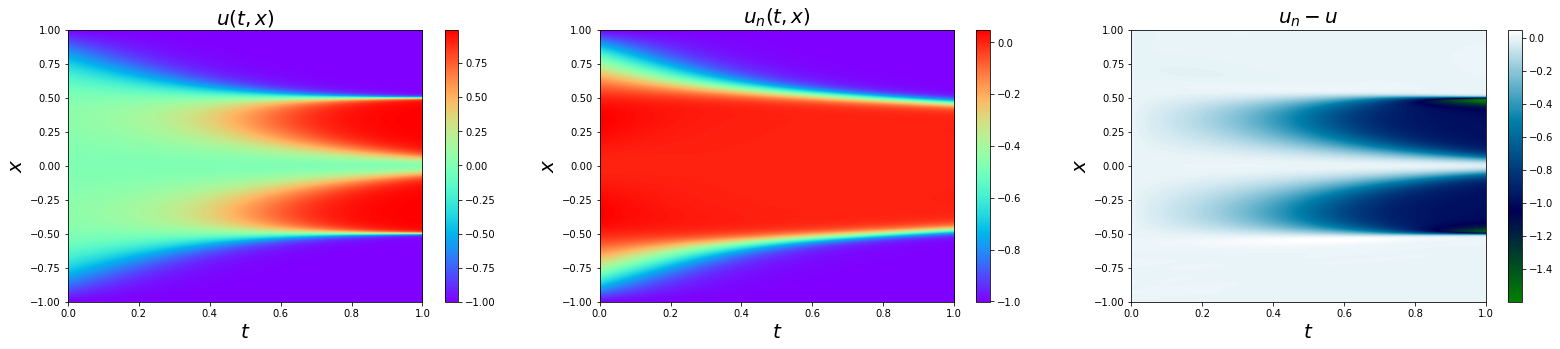

In [76]:
data = scipy.io.loadmat("./AC_R_1.mat")
x = data["x"]
t = data["tt"]
u_real = data["uu"].T

X,T = np.meshgrid(x,t)
X_p = np.concatenate((X.flatten()[:,None],T.flatten()[:,None]),axis=1)
u_predict = PINN.predict(X_p).reshape(X.shape)

fig = plt.figure(figsize=(27,5))
ax = fig.add_subplot(131)

h = ax.imshow(u_real.T,interpolation = "bilinear",cmap = "rainbow",
              extent = [t.min(), t.max(), x.min(), x.max()],
              origin = "lower", aspect= "auto")

cbar = fig.colorbar(h)

ax.set_xlabel("$t$",size = 20)
ax.set_ylabel("$x$",size = 20)
ax.set_title("$u(t,x)$",fontsize = 20)

ax2 = fig.add_subplot(132)

h = ax2.imshow(u_predict.T,interpolation = "bilinear",cmap = "rainbow",
              extent = [t.min(), t.max(), x.min(), x.max()],
              origin = "lower", aspect= "auto")

cbar = fig.colorbar(h)

ax2.set_xlabel("$t$",size = 20)
ax2.set_ylabel("$x$",size = 20)
ax2.set_title("$u_n(t,x)$",fontsize = 20)


ax3 = fig.add_subplot(133)
error = u_predict - u_real

h = ax3.imshow(error.T,interpolation = "bilinear",cmap = "ocean",
              extent = [t.min(), t.max(), x.min(), x.max()],
              origin = "lower", aspect= "auto")

cbar = fig.colorbar(h)

ax3.set_xlabel("$t$",size = 20)
ax3.set_ylabel("$x$",size = 20)
ax3.set_title("$u_n-u$",fontsize = 20)

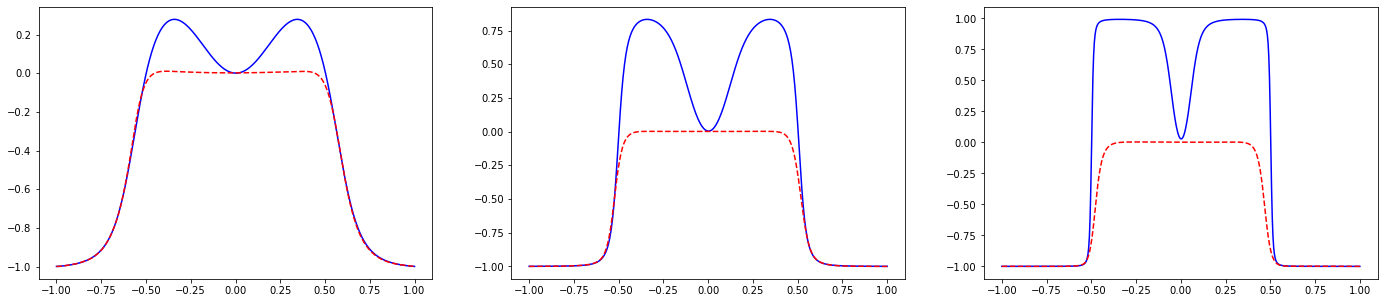

In [77]:
# 0.33, 0.66, 0.99
index_3 = np.where(t.flatten() == 0.33)[0].item()
index_6 = np.where(t.flatten() == 0.66)[0].item()
index_9 = np.where(t.flatten() == 0.99)[0].item()

u_3,u_p_3 = u_real[index_3,:],u_predict[index_3,:]
u_6,u_p_6 = u_real[index_6,:],u_predict[index_6,:]
u_9,u_p_9 = u_real[index_9,:],u_predict[index_9,:]

fig = plt.figure(figsize=(24,5))

ax = fig.add_subplot(131)
ax.plot(x[0],u_3,"b")
ax.plot(x[0],u_p_3,"r--")

ax = fig.add_subplot(132)
ax.plot(x[0],u_6,"b")
ax.plot(x[0],u_p_6,"r--")

ax = fig.add_subplot(133)
ax.plot(x[0],u_9,"b")
ax.plot(x[0],u_p_9,"r--")